# Objectif : Prédire si une tumeur est bénigne ou maligne à partir de mesures cliniques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# 📌 Bloc 1 : Présentation du projet + Chargement des données

df = pd.read_csv("/Users/alex/Desktop/albert-ml-project/data/data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Supprimer les colonnes inutiles
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

In [4]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
# Encodage de la variable cible : M = Malignant (1), B = Benign (0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

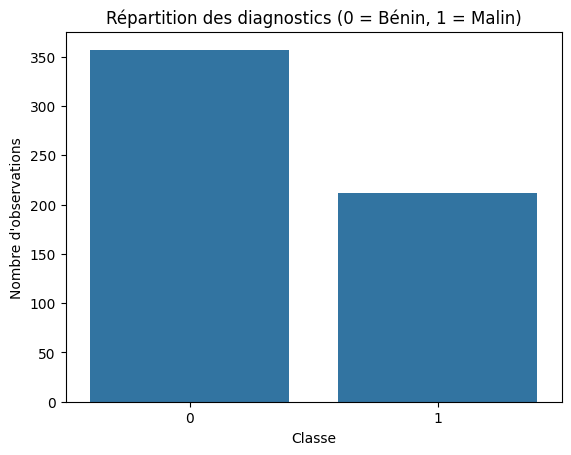

 Bénin : 62.74% — Malin : 37.26%


In [6]:
# Répartition des classes
sns.countplot(data=df, x='diagnosis')
plt.title("Répartition des diagnostics (0 = Bénin, 1 = Malin)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'observations")
plt.show()

# Affichage des proportions
benign = (df['diagnosis'] == 0).mean()
malignant = (df['diagnosis'] == 1).mean()
print(f" Bénin : {benign:.2%} — Malin : {malignant:.2%}")

In [7]:
# Statistiques globales
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


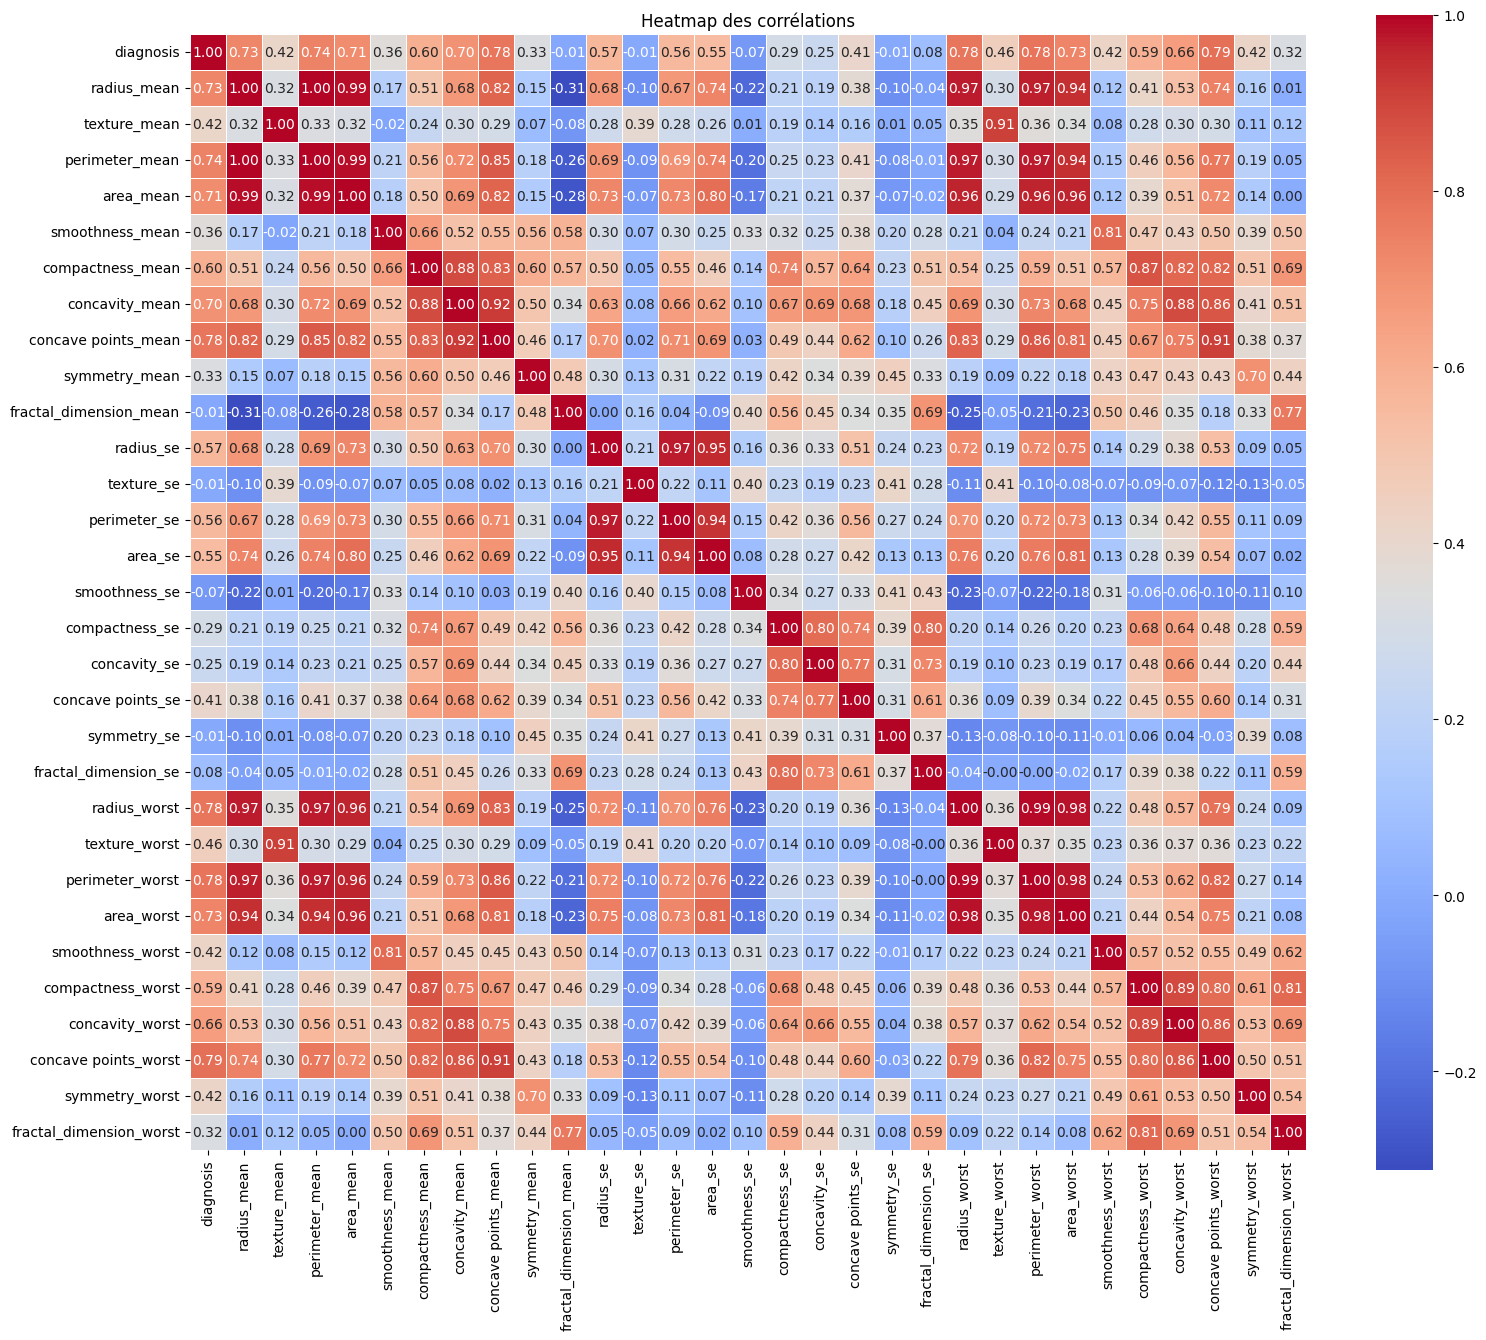

In [8]:
# Matrice de corrélation
corr_matrix = df.corr()

# Affichage heatmap avec les chiffres
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)
plt.title("Heatmap des corrélations")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparation X / y
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Découpage
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
# Création d’un dictionnaire de modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

# Stockage des scores
results = []

# Entraînement + évaluation pour chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3)
    })

# Affichage des résultats dans un DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1 Score", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.974,0.976,0.953,0.965
2,SVM,0.974,0.976,0.953,0.965
1,Random Forest,0.965,0.976,0.930,0.952


In [11]:
# Réentraîner LogisticRegression pour être sûr
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, y_train)

# Sauvegarde du modèle
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Sauvegarde du scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

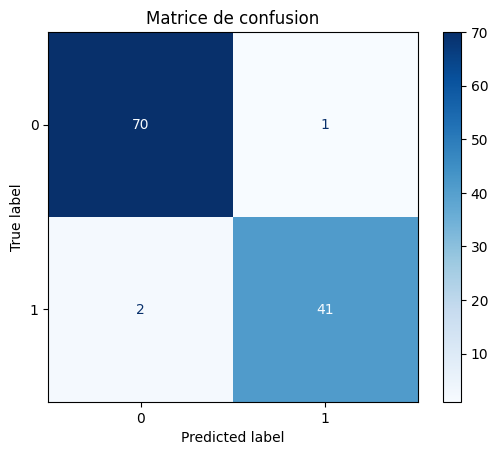

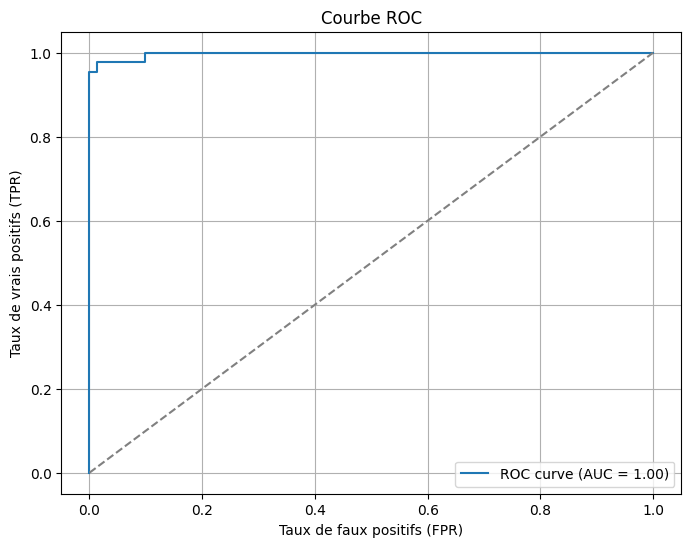

In [12]:
# Prédictions et probas pour la courbe ROC
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# ➤ Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

# ➤ Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [13]:
# Liste des colonnes/features
features = X.columns.tolist()

# Exemple de dictionnaire simulé (ou demander via widgets dans Jupyter)
sample_input = {feature: float(input(f"{feature}: ")) for feature in features}

# Transformation du dict en DataFrame
sample_df = pd.DataFrame([sample_input])

# Standardiser les inputs
sample_scaled = scaler.transform(sample_df)

# Prédiction
pred = final_model.predict(sample_scaled)[0]
proba = final_model.predict_proba(sample_scaled)[0]

print("\n🔍 Résultat de la prédiction :")
if pred == 0:
    print("✅ Tumeur bénigne")
else:
    print("⚠️ Tumeur maligne")

print(f"Probabilité bénigne : {proba[0]:.2%}")
print(f"Probabilité maligne : {proba[1]:.2%}")

ValueError: could not convert string to float: '24>5'

In [ ]:
3
